# KNN Model for predicting Age with Energy - Vibration

Import

In [25]:
import os
import glob
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.io import wavfile
from scipy.fft import fft
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from scipy.signal import find_peaks
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
# import openpyxl

Readwav function

In [38]:
def readAllFileVibration(folderPath):
    csv_data = []
    for root, dirs, files in os.walk(folderPath):
        for file in files:
            if file.endswith(".csv"):
                file_path = os.path.join(root, file)
                folder_name = os.path.basename(root)
                df = pd.read_csv(file_path)
                csv_data.append((df,folder_name,file))
    return csv_data
    
P1=readAllFileVibration("../../Data_Clean/Chanel0_Data_Columns/P1_clean")



print(P1)

[(             0
0    -0.015740
1    -0.024702
2    -0.018455
3    -0.009765
4    -0.012481
...        ...
2395 -6.419669
2396 -6.357747
2397 -6.365759
2398 -6.513911
2399 -6.443026

[2400 rows x 1 columns], 'RB', 'P1_RB_1_C_1.csv'), (             0
0     0.101858
1     0.100908
2     0.088822
3     0.095340
4     0.076057
...        ...
2395 -6.372956
2396 -6.304787
2397 -6.352179
2398 -6.419805
2399 -6.239334

[2400 rows x 1 columns], 'RB', 'P1_RB_1_C_2.csv'), (             0
0    -0.027011
1    -0.015061
2    -0.025109
3    -0.008814
4    -0.010308
...        ...
2395 -6.048950
2396 -6.033606
2397 -6.090504
2398 -6.039445
2399 -6.052345

[2400 rows x 1 columns], 'RB', 'P1_RB_1_C_3.csv'), (             0
0    -0.056873
1    -0.063527
2    -0.050491
3    -0.067737
4    -0.065293
...        ...
2395 -9.144644
2396 -9.230874
2397 -9.292660
2398 -9.368297
2399 -9.455342

[2400 rows x 1 columns], 'RB', 'P1_RB_1_S_1.csv'), (             0
0    -0.086748
1    -0.049948
2    -0.053343
3    -

Spectrum

In [27]:
def spectrumFromSignal(signal, sample_rate):
    spectrum = fft(signal[:, 0])  # Compute the FFT for the first column
    freqs = np.fft.fftfreq(len(spectrum), d=1/sample_rate)[:len(spectrum) // 2]  # Compute frequency bins
    spectrum = abs(spectrum[:len(spectrum) // 2])  # Compute magnitude of the spectrum

    # Filter the spectrum and frequencies between 150 Hz and 1000 Hz
    mask = (freqs >= 150) & (freqs <= 1000)
    return spectrum[mask], freqs[mask]

# testData = P1[0][1].to_numpy()
# # print(testData)
# testDataSpectrum, freqTest = spectrumFromSignal(testData, 20000)

Plot Spectrum

In [28]:
def plot_spectrum_with_freq(signal, freqs, title="Spectrum Plot"):
    magnitude = abs(signal)  # Compute magnitude of the spectrum

    plt.figure(figsize=(10, 6))
    plt.plot(freqs, magnitude)
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid()
    plt.show()  

# Example usage
# plot_spectrum_with_freq(testDataSpectrum, freqTest, title="Spectrum of Test Data")


Extract each peak and store

In [29]:
def extractNPeak(signal,smoothing=2,min_distance=100):
    # Ensure the signal is a 1-D array
    signalFile = signal.flatten()
    # Smooth the signal using a moving average filter
    window_size = smoothing  # Define the window size for smoothing
    smoothed_signal = np.convolve(signalFile, np.ones(window_size)/window_size, mode='same')
    signalFile = smoothed_signal
    # Find peaks in the signal
    peaks, _ = find_peaks(signalFile,100)
    
    return peaks


# peaks=extractNPeak(testDataSpectrum)

# # Plot the signal with the peaks
# plt.figure(figsize=(10, 6))
# plt.plot(testDataSpectrum, label="Signal")
# plt.scatter(peaks, testDataSpectrum[peaks], color="red", label="Peaks", zorder=5)
# plt.title("Signal with Peaks")
# plt.xlabel("Sample Index")
# plt.ylabel("Amplitude")
# plt.legend()
# plt.grid()
# plt.show()

Energy

In [30]:
def energy_per_frequency_band_from_spectrum(spectrum, freqs, band_width):
    # Calculate energy per band
    band_energies = []
    band_frequencies = []
    for start_freq in range(0, int(freqs[-1]), band_width):
        end_freq = start_freq + band_width
        band_indices = np.where((freqs >= start_freq) & (freqs < end_freq))[0]
        band_energy = np.sum(spectrum[band_indices]**2)  # Sum of squared magnitudes
        band_energies.append(band_energy)
        band_frequencies.append((start_freq + end_freq) / 2)  # Center frequency of the band

    return band_energies, band_frequencies

# energy_per_frequency_band_from_spectrum(testDataSpectrum,freqTest,50)

# Main

In [52]:
raquetteTypeList = {"RB":0,"RO":1,"RR":2,"RV":3}
raquetteAgeList = {"P1":1,"P2":2,"P3":3}


P1 = readAllFileVibration("../../Data_Clean/Chanel0_Data_Columns/P1_clean")
P2 = readAllFileVibration("../../Data_Clean/Chanel0_Data_Columns/P2_clean")
P3 = readAllFileVibration("../../Data_Clean/Chanel0_Data_Columns/P3_clean")

print(len(P1), len(P2), len(P3))

# Combine all data into a single DataFrame with equal repartition of ages
all_data = []

# Find the minimum number of samples across all ages
min_samples_per_age = min(len(P1), len(P2), len(P3))

freq = []

#P1

for index in range(len(P1)):
    signal = np.array(P1[0][index])
    filesP1= P1[index]
    print(filesP1)
    spectrum_points, freq = spectrumFromSignal(signal, 20000)  # Compute the spectrum from the signal
    all_data.append({
        "Signal": signal,
        "Spectrum": spectrum_points,
        "Label": filesP1[3:4],
        "Age": filesP1[0:1],
        "Position": filesP1[7],
        "FileName": filesP1[index]  # Add the file name to the data
    })

#P2
for index in range(len(P2)):
    signal = np.array(P2[index])
    filesP2= P2[2]
    spectrum_points, freq = spectrumFromSignal(signal, 20000)  # Compute the spectrum from the signal
    all_data.append({
        "Signal": signal,
        "Spectrum": spectrum_points,
        "Label": filesP2[3:4],
        "Age": filesP2[0:1],
        "Position": filesP2[8],
        "FileName": filesP2[index]  # Add the file name to the data
    })
#P3
for index in range(len(P3)):
    signal = np.array(P3[index])
    filesP3= P3[2]
    spectrum_points, freq = spectrumFromSignal(signal, 20000)  # Compute the spectrum from the signal
    all_data.append({
        "Signal": signal,
        "Spectrum": spectrum_points,
        "Label": filesP3[3:4],
        "Age": filesP3[0:1],
        "Position": filesP3[8],
        "FileName": filesP3[index]  # Add the file name to the data
    })

# Convert the list of dictionaries into a DataFrame
df_combined = pd.DataFrame(all_data)
print(df_combined)

# Define the band width
band_width = 20

# Liste pour stocker les résultats
results = []

# Compute the frequencies corresponding to the spectrum
for band_width in range(10,120,10):

    # Compute energy per band for each row in the DataFrame
    df_combined['EnergyPerBand'] = df_combined['Spectrum'].apply(
        lambda spectrum: energy_per_frequency_band_from_spectrum(np.array(spectrum), freq, band_width)[0]
    )

    # print(df_combined)


    # Combine features into X
    X = np.array([
        np.concatenate((energy_band, freq[:len(energy_band)]))
        for energy_band in df_combined["EnergyPerBand"].tolist()
    ])
    # X=np.array(X_AmplitudeAllWavFile)


    # Encode string labels into integers
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df_combined["Age"])

    # # print(y)
    # print(len(X),len(y))

    # Diviser les données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # print(X,y)

    # Définir les bonnes valeurs trouvé
    n_neighbors = 10  # Nombre de voisins
    weights_options = ['uniform']  # Méthode de pondération
    metric_options = ['manhattan']  # Métriques


    # Définir les plages de valeurs pour les hyperparamètres
    n_neighbors_range = range(1, 21)  # Nombre de voisins
    weights_options = ['uniform', 'distance']  # Méthode de pondération
    metric_options = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']  # Métriques



    # Tester toutes les combinaisons d'hyperparamètres
    for n_neighbors in n_neighbors_range:
        for weights in weights_options:
            for metric in metric_options:
                # Créer et entraîner le modèle KNN
                knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
                knn.fit(X_train, y_train)

                # Évaluer sur l'ensemble de test
                y_pred = knn.predict(X_test)
                accuracy_test = accuracy_score(y_test, y_pred)

                # Évaluer sur l'ensemble d'entraînement
                y_train_pred = knn.predict(X_train)
                accuracy_train = accuracy_score(y_train, y_train_pred)

                # Ajouter les résultats à la liste
                results.append({
                    'band_width': band_width,
                    'n_neighbors': n_neighbors,
                    'weights': weights,
                    'metric': metric,
                    'accuracy_train': accuracy_train,
                    'accuracy_test': accuracy_test
                })

# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)



print(results_df)

216 324 255
(             0
0    -0.015740
1    -0.024702
2    -0.018455
3    -0.009765
4    -0.012481
...        ...
2395 -6.419669
2396 -6.357747
2397 -6.365759
2398 -6.513911
2399 -6.443026

[2400 rows x 1 columns], 'RB', 'P1_RB_1_C_1.csv')


IndexError: tuple index out of range

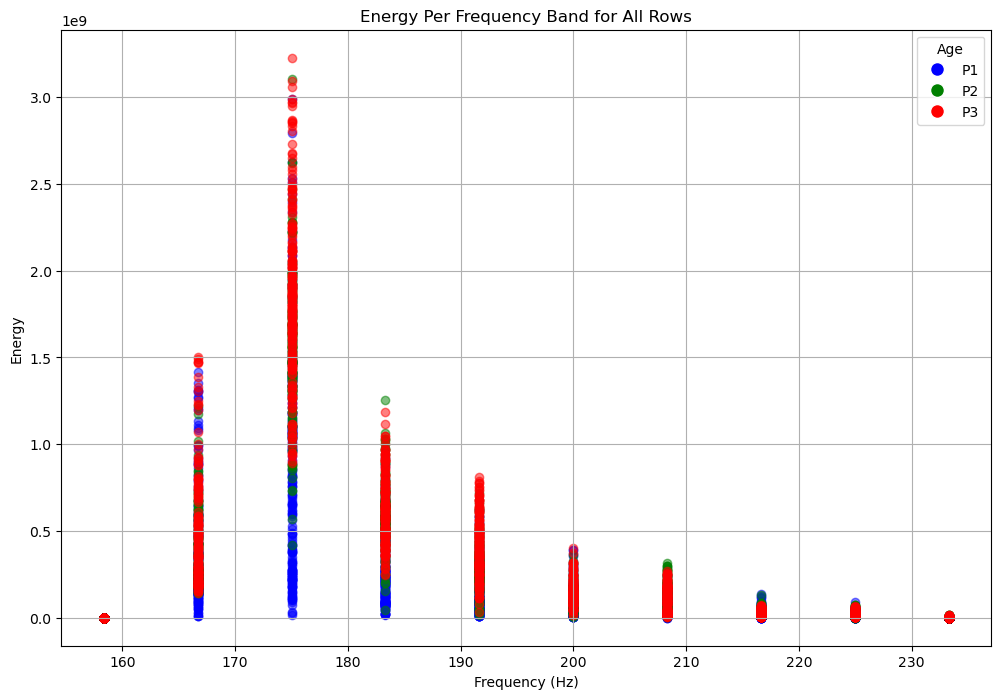

In [ ]:
# Define a color map for each age
age_color_map = {"P1": "blue", "P2": "green", "P3": "red"}

# Iterate through all rows in the DataFrame
plt.figure(figsize=(12, 8))
for index, row in df_combined.iterrows():
    energy_per_band = row['EnergyPerBand']
    band_frequencies = freq[:len(energy_per_band)]
    age = row['Age']
    plt.scatter(band_frequencies, energy_per_band, color=age_color_map[age], label=f"Age {age}" if index == 0 else "", alpha=0.5)

# Add labels and title
plt.title("Energy Per Frequency Band for All Rows")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Energy")
plt.grid()
# Add a legend for the colors
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=age) for age, color in age_color_map.items()]
plt.legend(handles=handles, title="Age", loc='upper right')
plt.show()

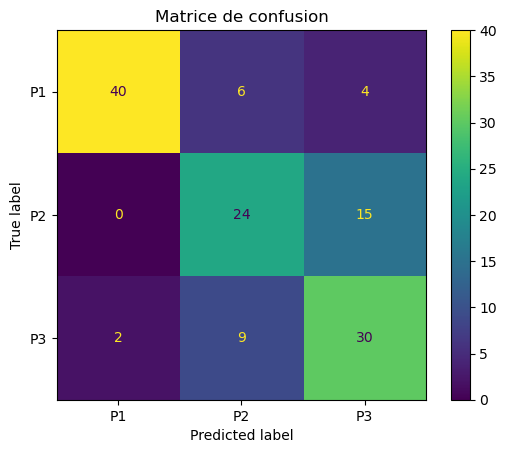

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Afficher la matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder.classes_)
plt.title("Matrice de confusion")
plt.show()
